# Project 3

This project requires the implementation of an image classifier based on convolutional neural networks. The provided dataset (from [Lazebnik et al., 2006]),
contains 15 categories (office, kitchen, living room, bedroom, store, industrial,
tall building, inside city, street, highway, coast, open country, mountain, forest,
suburb), and is already divided in training set and test set.

### 1. train a shallow network

Libraries used.

In [25]:
import keras as ks
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Activation
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import os
import glob
import cv2 as cv2

In [26]:
import utility as ut
from buildDataSet import retrieve_from, reshape

This first part is dedicated to data preprocessing.

In [27]:
#path to the directories
PATH_TRAIN=r'C:\Users\eleon\Documents\Uni_Trieste\DSSC_II_year_I_semester\Computer Vision\Exam\train'
PATH_TEST=r'C:\Users\eleon\Documents\Uni_Trieste\DSSC_II_year_I_semester\Computer Vision\Exam\test'

#array of the class
LABELS=[os.path.basename(i) for i in glob.glob(PATH_TRAIN + '/*', recursive=True)]
NUM_CLASSES = len(LABELS) #15
print("Class number: ", NUM_CLASSES)
print("Class names: ", LABELS)

Class number:  15
Class names:  ['Bedroom', 'Coast', 'Forest', 'Highway', 'Industrial', 'InsideCity', 'Kitchen', 'LivingRoom', 'Mountain', 'Office', 'OpenCountry', 'Store', 'Street', 'Suburb', 'TallBuilding']


In [28]:
#retrieve images from the directory and split the data set
X_train_raw, y_train_raw = retrieve_from(PATH_TRAIN, LABELS)
X_test, y_test = retrieve_from(PATH_TEST, LABELS)

print('Image Dimensions : ',X_test[0].shape)
print('len train x: ',len(X_train_raw))
print('len test x: ',len(X_test))
print('len train y: ',len(y_train_raw))
print('len test y: ',len(y_test))

Image Dimensions :  (200, 276)
len train x:  1500
len test x:  2985
len train y:  1500
len test y:  2985


Print a sample image to check the correctness of the procedure.

In [29]:
cv2.imshow("Initial image", X_train_raw[9])
cv2.waitKey(0)
cv2.destroyAllWindows()
#note: remember to close the images to procede

Data manipulation.

In [30]:
# Resize the images in a proper dimension
X_train_raw = reshape(X_train_raw, width = 64, height = 64, channel = 1)
X_test = reshape(X_test, width = 64, height = 64, channel = 1)

# Use One-Hot Encoding to convert the labels into a set of numbers to input into the neural network.
y_train_one_hot = to_categorical(y_train_raw)
y_test_one_hot = to_categorical(y_test)

# Split the training set between train 85% and validation set 15%
X_train, X_validation, y_train, y_validation = train_test_split(
    X_train_raw, y_train_one_hot, train_size=0.85, random_state=42)

print('Train set dimintion: ',len(X_train))
print('Validation set dimintion: ',len(X_validation))
print('Test set dimintion: ',len(X_test))

Train set dimintion:  1275
Validation set dimintion:  225
Test set dimintion:  2985


To build the model we need to create the given architecture using Sequential() and add the first layer, a convolution layer to extract features from the input image.

In [31]:
# initial weights drawn from a Gaussian distribution with a mean of 0 and a standard deviation of 0.01
norm = ks.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None)

# employ Stochastic gradient descent with momentum optimization algorithm
sgd = ks.optimizers.SGD(momentum=0.9,nesterov=True)

base_model = Sequential([
    Conv2D(8, 3,strides=1, padding='same',input_shape=(64,64,1)),
    Activation('relu'),
    MaxPooling2D(pool_size=2,strides=2),
    Conv2D(16, 3,strides=1, padding='same'),
    Activation('relu'),
    MaxPooling2D(pool_size=2,strides=2),
    Conv2D(32, 3,strides=1, padding='same'),
    Activation('relu'),
    Flatten(),
    #set the initial bias values to 0
    Dense(NUM_CLASSES, activation='softmax',kernel_initializer=norm, bias_initializer='zeros')
])

base_model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics = ['accuracy'])

Visualize training results, since we don't know the best number of epochs we compute a stopping critera .

In [32]:
es = EarlyStopping(monitor='val_loss', patience=5)
#use batch sized of 32
batch_sz = 32

base_history=base_model.fit(
    X_train,
    y_train,
    batch_size=batch_sz,
    epochs=20,
    validation_data=(X_validation,y_validation),
    shuffle=True,
    callbacks=[es]
)

Train on 1275 samples, validate on 225 samples
Epoch 1/20
1275/1275 [==============================] - 3s 2ms/step - loss: 2.7080 - accuracy: 0.0745 - val_loss: 2.7039 - val_accuracy: 0.0978

Plot the model and the results

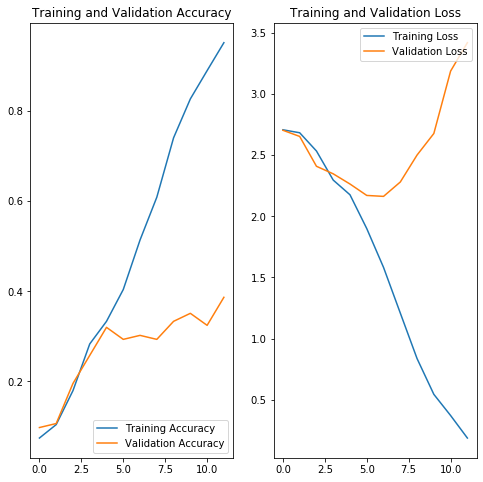

<Figure size 432x288 with 0 Axes>

In [33]:
ut.plot_acc_loss(base_history)
plt.savefig("accuracy and loss base model");

Print the accuracy and loss for the test set

In [34]:
base_loss, base_accuracy = base_model.evaluate(X_test,y_test_one_hot)
print("loss: {:.2f}".format(base_loss))
print("accuracy: {:.2f}".format(base_accuracy))

2985/2985 [==============================] - ETA: 0s

Plot normalized confusion matrix

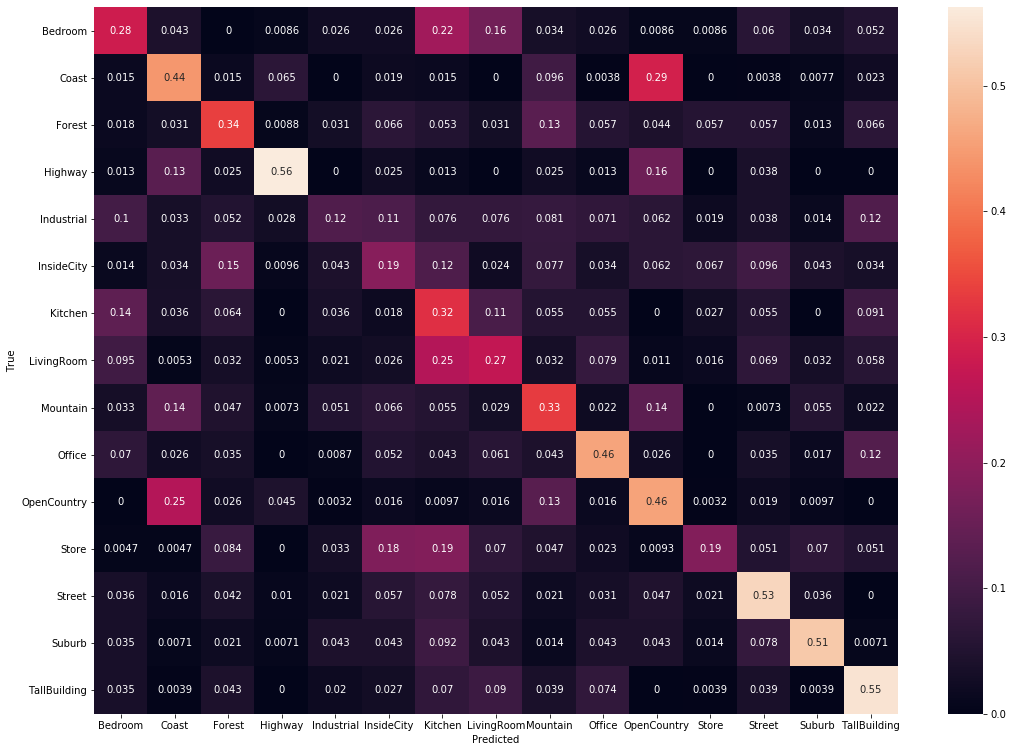

In [35]:
y_pred_base = base_model.predict_classes(X_test)
ut.plot_confusion_matrix(y_test,y_pred_base, LABELS)
plt.savefig("confusion matrix base model");

In [36]:
print('Classification Report')
print(ut.classification_report(y_test, y_pred_base, target_names=LABELS))


Classification Report
              precision    recall  f1-score   support

     Bedroom       0.24      0.28      0.26       116
       Coast       0.40      0.44      0.42       260
      Forest       0.37      0.34      0.35       228
     Highway       0.65      0.56      0.60       160
  Industrial       0.28      0.12      0.17       211
  InsideCity       0.21      0.19      0.20       208
     Kitchen       0.13      0.32      0.18       110
  LivingRoom       0.28      0.27      0.27       189
    Mountain       0.34      0.33      0.33       274
      Office       0.33      0.46      0.38       115
 OpenCountry       0.42      0.46      0.44       310
       Store       0.47      0.19      0.27       215
      Street       0.46      0.53      0.50       192
      Suburb       0.51      0.51      0.51       141
TallBuilding       0.56      0.55      0.55       256

    accuracy                           0.37      2985
   macro avg       0.38      0.37      0.36      2985
weig